In [1]:
import matplotlib.pyplot as plt
import torch

from ptvi.algos.fivo import *
from ptvi import sgvb

In [2]:
torch.manual_seed(123)
T = 200
model = FilteredStochasticVolatilityModel(
    input_length=T, proposal=AR1Proposal(0, .95), num_particles=50)
model

Stochastic volatility model:
	x_t = exp(a * z_t/2) ε_t      t=1,...,200
	z_t = b + c * z_{t-1} + ν_t,  t=2,...,200
	z_1 ~ N(b, sqrt(1/(1 - c^2)))
	where ε_t, ν_t ~ Ν(0,1)

In [3]:
params = dict(a=1., b=0., c=.95)
y, z_true = model.simulate(**params)

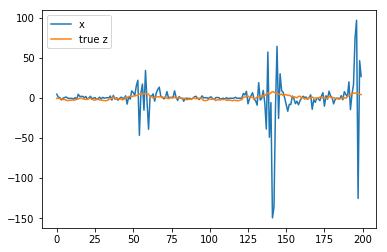

In [4]:
plt.plot(y.numpy(), label='x')
plt.plot(z_true.numpy(), label='true z')
plt.legend();

In [5]:
fit = sgvb(model, y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference: Particle filtered stochastic volatility model
  - Estimating elbo with M=1;
  - Minimum supremum growth heuristic (min_steps=500, patience=20, skip=10, ε=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


RuntimeError: The size of tensor a (200) must match the size of tensor b (50) at non-singleton dimension 0

In [ ]:
plt.plot(fivos);